In [11]:
import os
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout, LayerNormalization, MultiHeadAttention
from keras.optimizers import SGD

In [12]:
import tensorflow as tf

# Check if GPU is available
gpu_available = tf.config.list_physical_devices('GPU')

if gpu_available:
    print("CUDA and GPU support is available.")
else:
    print("CUDA and GPU support is not available.")

CUDA and GPU support is available.


In [13]:
PATH = "/home/user/repos/DL1"
PATH_TRAIN  = PATH + "/DATASET/train"
PATH_TEST   = PATH + "/DATASET/test"
PATH_VALID  = PATH + "/DATASET/valid"
PATH_MODELS = PATH + "/MODELS/"

In [14]:
IMAGE_SIZE = (32, 32)
INPUT_SHAPE = (32, 32, 3)
BATCH_SIZE = 128
NUM_CLASSES = 10
EPOCHS = 5
SEED = 69
DEFAULT_OPTIMIZER = 'adam'
DEFAULT_LOSS = 'categorical_crossentropy'

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=10,  # Rotate images by up to 20 degrees
    width_shift_range=0.1,  # Shift width by up to 20% of total width
    height_shift_range=0.1,  # Shift height by up to 20% of total height
    shear_range=0.1,  # Apply shear transformation by up to 20 degrees
    zoom_range=0.1,  # Zoom in by up to 20%
    horizontal_flip=True,  # Flip horizontally with a probability of 50%
    fill_mode='nearest'  # Use nearest fill mode for newly created pixels
)
test_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
)

train_generator = train_datagen.flow_from_directory(
    PATH_TRAIN,
    seed=SEED,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

test_generator = test_datagen.flow_from_directory(
    PATH_TEST,
    seed=SEED,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)


Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.


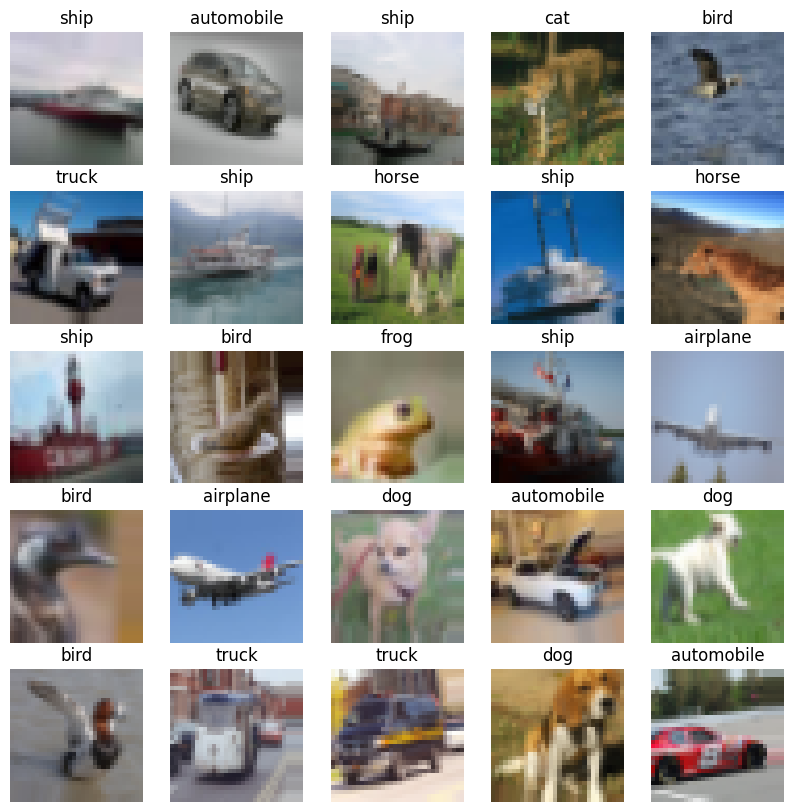

In [16]:
images, labels = next(train_generator)

class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(10, 10))
for i in range(min(len(images), 25)):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])  
    plt.title(f"{class_names[labels[i].argmax()]}")
    plt.axis("off")
plt.show()


In [17]:
class BaseModel(ABC):
    def __init__(self, input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, optimizer=DEFAULT_OPTIMIZER, loss=DEFAULT_LOSS):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.optimizer = optimizer
        self.loss = loss

        self.model = self.create_model()
        self.compile_model()

    @abstractmethod
    def create_model(self):
        pass

    def compile_model(self):
        self.model.compile(optimizer=self.optimizer,
                           loss=self.loss,
                           metrics=['accuracy'])

    def train(self, train_generator, epochs=EPOCHS):
        history = self.model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // BATCH_SIZE,
            epochs=epochs
        )
        return history

    def evaluate(self, test_generator):
        test_loss, test_accuracy = self.model.evaluate(test_generator)
        return test_accuracy



In [18]:
class CNN(BaseModel):
    def __init__(self, input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, optimizer=DEFAULT_OPTIMIZER, loss=DEFAULT_LOSS):
        super().__init__(input_shape, num_classes, optimizer, loss)
    def create_model(self):
        return tf.keras.Sequential([
            tf.keras.layers.Input(shape=self.input_shape),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1024, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(self.num_classes, activation='softmax')
        ])

In [19]:
class CNN_with_dropout(BaseModel):
    def __init__(self, input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, optimizer=DEFAULT_OPTIMIZER, loss=DEFAULT_LOSS, dropout_rate=0.3):
        self.dropout_rate = dropout_rate
        super().__init__(input_shape, num_classes, optimizer, loss)
    def create_model(self):
        return tf.keras.Sequential([
            tf.keras.layers.Input(shape=self.input_shape),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(self.dropout_rate),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(self.dropout_rate),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1024, activation='relu'),
            tf.keras.layers.Dropout(self.dropout_rate),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(self.dropout_rate),
            tf.keras.layers.Dense(self.num_classes, activation='softmax')
        ])

In [20]:
class ResNet32(BaseModel):
    def __init__(self, input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, optimizer=DEFAULT_OPTIMIZER, loss=DEFAULT_LOSS):
        super().__init__(input_shape, num_classes, optimizer, loss)

    def residual_block(self, x, filters, downsample=False):
        strides = 2 if downsample else 1

        identity = x

        x = tf.keras.layers.Conv2D(filters, kernel_size=3, strides=strides, padding='same', activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', activation=None)(x)
        x = tf.keras.layers.BatchNormalization()(x)

        if downsample:
            identity = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same')(identity)
            identity = tf.keras.layers.BatchNormalization()(identity)

        x = tf.keras.layers.add([x, identity])
        x = tf.keras.layers.Activation('relu')(x)
        return x

    def create_model(self):
        inputs = tf.keras.layers.Input(shape=self.input_shape)

        x = tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
        x = tf.keras.layers.BatchNormalization()(x)

        x = self.residual_block(x, 64)
        x = self.residual_block(x, 64)
        x = self.residual_block(x, 128, downsample=True)
        x = self.residual_block(x, 128)

        x = tf.keras.layers.GlobalAveragePooling2D()(x)

        outputs = tf.keras.layers.Dense(self.num_classes, activation='softmax')(x)

        return tf.keras.Model(inputs, outputs)

In [21]:
class ResNeXt32(BaseModel):
    def __init__(self, input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, optimizer=DEFAULT_OPTIMIZER, loss=DEFAULT_LOSS):
        super().__init__(input_shape, num_classes, optimizer, loss)


    def create_model(self):
        def residual_block(inputs, filters, cardinality=16, strides=(1, 1)):
            shortcut = inputs
            
            splits = filters // cardinality
            groups = []
            for i in range(cardinality):
                group = tf.keras.layers.Conv2D(splits, kernel_size=(1, 1), strides=strides, padding='same')(inputs)
                groups.append(group)
            group_merge = tf.keras.layers.concatenate(groups, axis=-1)
            conv1 = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), strides=(1, 1), padding='same')(group_merge)
            conv1 = tf.keras.layers.BatchNormalization()(conv1)
            conv1 = tf.keras.layers.ReLU()(conv1)
            
            conv2 = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(conv1)
            conv2 = tf.keras.layers.BatchNormalization()(conv2)
            conv2 = tf.keras.layers.ReLU()(conv2)

            conv3 = tf.keras.layers.Conv2D(filters * 2, kernel_size=(1, 1), strides=(1, 1), padding='same')(conv2)
            conv3 = tf.keras.layers.BatchNormalization()(conv3)

            shortcut = tf.keras.layers.Conv2D(filters * 2, kernel_size=(1, 1), strides=strides, padding='same')(shortcut)
            shortcut = tf.keras.layers.BatchNormalization()(shortcut)

            output = tf.keras.layers.add([conv3, shortcut])
            output = tf.keras.layers.ReLU()(output)

            return output
        
        input_layer = tf.keras.layers.Input(shape=self.input_shape)
        x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same')(input_layer)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

        x = residual_block(x, filters=64)
        x = residual_block(x, filters=64)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = residual_block(x, filters=128)
        x = residual_block(x, filters=128)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)

        x = tf.keras.layers.Dense(1024, activation='relu')(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)

        output_layer = tf.keras.layers.Dense(self.num_classes, activation='softmax')(x)

        model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

        return model

In [22]:
class VGG32(BaseModel):
    def __init__(self, input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, optimizer=DEFAULT_OPTIMIZER, loss=DEFAULT_LOSS):
        super().__init__(input_shape, num_classes, optimizer, loss)

    def conv_block(self, x, filters, kernel_size):
        x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
        x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        return x

    def create_model(self):
        inputs = tf.keras.layers.Input(shape=self.input_shape)

        x = self.conv_block(inputs, 32, (3, 3))
        x = self.conv_block(x, 64, (3, 3))
        x = self.conv_block(x, 128, (3, 3))

        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(512, activation='relu')(x)
        x = tf.keras.layers.Dense(self.num_classes, activation='softmax')(x)

        return tf.keras.Model(inputs, x)

In [23]:
class ViT(BaseModel):
    def __init__(self, input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, optimizer=DEFAULT_OPTIMIZER, loss=DEFAULT_LOSS):
        super().__init__(input_shape, num_classes, optimizer, loss)

    def create_model(self):
        num_layers = 3 
        num_heads = 6 
        hidden_size = 64  

        inputs = tf.keras.Input(shape=self.input_shape)

        patch_size = (4, 4)
        num_patches = (self.input_shape[0] // patch_size[0]) * (self.input_shape[1] // patch_size[1])
        patch_embedding = tf.keras.layers.Conv2D(hidden_size, kernel_size=patch_size, strides=patch_size, padding="same")(inputs)
        patch_embedding = tf.keras.layers.Reshape((num_patches, hidden_size))(patch_embedding)

        positions = tf.range(num_patches)[:, tf.newaxis]
        positions = tf.keras.layers.Embedding(input_dim=num_patches, output_dim=hidden_size)(positions)
        positions = tf.reshape(positions, [1, num_patches, hidden_size])  
        positions = tf.tile(positions, [tf.shape(patch_embedding)[0], 1, 1]) 
        embeddings = patch_embedding + positions

        for _ in range(num_layers):
            attention_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_size)(embeddings, embeddings)
            embeddings = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_output + embeddings)
            ff_output = tf.keras.layers.Dense(hidden_size, activation='relu')(embeddings) 
            ff_output = tf.keras.layers.Dense(hidden_size)(ff_output) 
            ff_output = tf.keras.layers.Dropout(0.1)(ff_output)
            embeddings = tf.keras.layers.LayerNormalization(epsilon=1e-6)(ff_output + embeddings)

        cls_token = embeddings[:, 0, :]
        outputs = tf.keras.layers.Dense(self.num_classes, activation="softmax")(cls_token)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model

In [24]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train'], loc='upper left')
    plt.show()

In [25]:
optimizer = 'nadam'


model = ResNeXt32(optimizer=optimizer)
model.model.summary()

2024-04-07 18:34:56.353849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 18:34:56.354438: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-07 18:34:56.354773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-07 18:34:56.355023: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 16, 16, 64)   0           ['batch_normalization[0][0]']

In [26]:
# traim
history = model.train(train_generator, epochs=EPOCHS)

# eval
test_accuracy = model.evaluate(test_generator)

# check
print("Test Accuracy:", test_accuracy)

Epoch 1/5


2024-04-07 18:35:15.527018: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2024-04-07 18:35:16.004259: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 232.25MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-07 18:35:16.004300: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 232.25MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-07 18:35:16.334365: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 232.25MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gain

703/703 [==============================] - 111s 98ms/step - loss: 1.4807 - accuracy: 0.4540
Epoch 2/5
703/703 [==============================] - 56s 80ms/step - loss: 1.2389 - accuracy: 0.5523
Epoch 3/5
703/703 [==============================] - 56s 79ms/step - loss: 1.1400 - accuracy: 0.5892
Epoch 4/5
703/703 [==============================] - 56s 79ms/step - loss: 1.0800 - accuracy: 0.6117
Epoch 5/5
704/704 [==============================] - 34s 47ms/step - loss: 1.1608 - accuracy: 0.5883
Test Accuracy: 0.5883111357688904


In [27]:
# model_name = 'ACC058_2-5MPARAMS_CNN_NODROP_AUG_NADAM_EPOCH5.tf'
# model_name = 'ACC056_2-5MPARAMS_CNN_DROP03_AUG_NADAM_EPOCH5.tf'
model_name = 'ACC065_0-7MPARAMS_RES_NODROP_AUG_NADAM_EPOCH5.tf'
# model_name = 'ACC065_2-7MPARAMS_RES_NODROP_AUG_NADAM_EPOCH5.tf'
# model_name = 'ACC064_1-3MPARAMS_VGG_NODROP_AUG_NADAM_EPOCH5.tf'
# model_name = 'ACC047_0-4MPARAMS_VIT_DROP01_AUG_NADAM_EPOCH5.tf'
# model_name = 'ACC057_1-2MPARAMS_REX_NODROP_AUG_NADAM_EPOCH5.tf'

if os.path.exists(PATH_MODELS + model_name):
    print(f"Warning: Model file already exists.")
else:
    model.model.save(PATH_MODELS + model_name)
    print("Model saved successfully.")

INFO:tensorflow:Assets written to: /home/user/repos/DL1/MODELS/ACC065_0-7MPARAMS_RES_NODROP_AUG_NADAM_EPOCH5.tf/assets


INFO:tensorflow:Assets written to: /home/user/repos/DL1/MODELS/ACC065_0-7MPARAMS_RES_NODROP_AUG_NADAM_EPOCH5.tf/assets


Model saved successfully.
